In [37]:
# load dataset via github

!wget "https://raw.githubusercontent.com/farisi55/customer-churn-prediction/main/data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"


--2024-06-13 04:00:16--  https://raw.githubusercontent.com/farisi55/customer-churn-prediction/main/data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970457 (948K) [text/plain]
Saving to: ‘WA_Fn-UseC_-Telco-Customer-Churn.csv’

WA_Fn-UseC_-Telco-C 100%[===================>] 947.71K  --.-KB/s    in 0.04s   

2024-06-13 04:00:16 (24.2 MB/s) - ‘WA_Fn-UseC_-Telco-Customer-Churn.csv’ saved [970457/970457]



In [ ]:
# Data handling
import pandas as pd
import numpy as np


# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.offline as po
import plotly.graph_objs as go
import plotly.express as px
%matplotlib inline

# EDA (pandas-profiling, etc. )
#import ydata_profiling as pp
# Feature Processing (Scikit-learn processing, etc. )
import sklearn
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
...
# Other packages
import os, pickle
import warnings
warnings.filterwarnings("ignore")

# exporting
import joblib

In [ ]:
def read_data(path):
    df = pd.read_csv(path)
    return df

In [ ]:
def export_object(obj, output_name):
    joblib.dump(obj, output_name)

In [ ]:
def prepare_data(df, test_size=0.2):

    ###### data converting

    # convert string values 'yes' and 'no' to numeric values '1' and '0' in churn column because of our ML model
      df.loc[df.Churn == 'Yes','Churn'] = 1
      df.loc[df.Churn == 'No','Churn'] = 0

    # convert string values 'Female' and 'Male' to numeric values '1' and '0' in gender column
      df.loc[df.gender == 'Female','gender'] = 1
      df.loc[df.gender == 'Male','gender'] = 0

    # convert 'No internet service' to 'No' for columns 'OnlineBackup','StreamingMovies','DeviceProtection','TechSupport','OnlineSecurity','StreamingTv'
      cols = ['OnlineBackup','StreamingMovies','DeviceProtection','TechSupport','OnlineSecurity','StreamingTV']
      for i in cols :
          df[i] = df[i].replace({'No internet service': 'No'})

    #Replace 'No internet service' and 'No phone service' with 'No'
      df.replace(['No internet service','No phone service'], 'No', inplace=True)

    #Replaces the spaces with null values
      df['TotalCharges'] = df["TotalCharges"].replace(" ",np.nan)

    #Convert 'TotalCharges' column to float datatype
      df['TotalCharges'] = df["TotalCharges"].astype(float)

    ##### Data Endcoding

    # Columns to be one-hot encoded
      columns_to_encode = ['Contract', 'gender', 'DeviceProtection', 'MultipleLines', 'InternetService',
                     'OnlineBackup', 'OnlineSecurity', 'PaymentMethod', 'SeniorCitizen', 'StreamingMovies',
                     'StreamingTV', 'TechSupport', 'TotalCharges']
    # One-hot encoding
      onehot_encoder = OneHotEncoder(sparse=False)
      onehot_encoded = onehot_encoder.fit_transform(pd.DataFrame(df)[columns_to_encode])

    # Create a new DataFrame with one-hot encoded columns
      df_onehot = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(columns_to_encode))

    ###### data scaling

    # The columns to perform feature scaling on are 'tenure','MonthlyCharges' to have them on one scale
      Cols_ft_scaling = ['tenure','MonthlyCharges']

    # Perform feature scaling on the dataset using the fit_transform method
      standardScaler = StandardScaler()
      scaled_features = standardScaler.fit_transform(df[Cols_ft_scaling])

    # Creating a new DataFrame with scaled features
      df_scaled = pd.DataFrame(scaled_features, columns=Cols_ft_scaling)

    # Create a DataFrame with scaled and encoded features
      df_processed = pd.concat([df_scaled, df_onehot, df['Churn']], axis=1)

    # select features
    # Assigning all the feature columns to variable x and target to variable y
      y = df_processed['Churn']
      X = df_processed.drop(columns=['Churn'],axis=1)

    # separate features and target
     #train_features = df[feature].copy()
     #train_target = df[target].copy()

    # split data to train and test
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    #### Training data ####


    #### Testing data ####


      return X_train, X_test, y_train, y_test

In [ ]:
def evaluate(labels, predictions, classes=None):
    print(f"Accuracy: {accuracy_score(labels, predictions):.3f}")
    print(f"F1 Score: {f1_score(labels, predictions, average='micro'):.3f}")
    print(classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions, labels=classes)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot()
    plt.show()

In [ ]:
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    evaluate(y_test, predictions, classes=model.classes_)

    return model

In [ ]:
def run_ml(model, data_path, test_size=0.2, output_name="model.joblib"):
    # read data
    df = read_data(data_path)

    # preprocess data
    X_train, X_test, y_train, y_test = prepare_data(df, test_size)

    # train model
    model = train_evaluate_model(model, X_train, X_test, y_train, y_test)

    # export model
    export_object(model, output_name=output_name)

# Training Model

##Logistic Regression Model

Logistic Regression Model

Accuracy: 0.817
F1 Score: 0.817
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.59      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.75      1409
weighted avg       0.81      0.82      0.81      1409



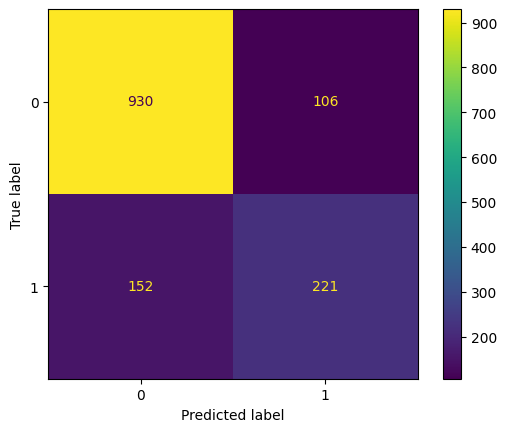

In [ ]:
logregmodel = LogisticRegression(C= 1, penalty='l2')

print('Logistic Regression Model')
print()
run_ml(logregmodel, data_path='./WA_Fn-UseC_-Telco-Customer-Churn.csv', test_size=0.2, output_name="logregmodel.joblib")

## Support Vector Machine

Support Vector Machine

Accuracy: 0.807
F1 Score: 0.807
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1036
           1       0.65      0.59      0.62       373

    accuracy                           0.81      1409
   macro avg       0.75      0.74      0.74      1409
weighted avg       0.80      0.81      0.80      1409



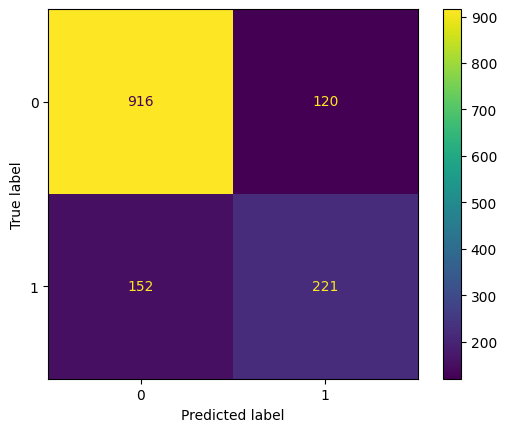

In [ ]:
svcmodel = SVC(kernel='linear',random_state=42,probability=True)

print('Support Vector Machine')
print()
run_ml(svcmodel, data_path='./WA_Fn-UseC_-Telco-Customer-Churn.csv', test_size=0.2, output_name="svcmodel.joblib")

##K-Nearest Neighbor

K-Nearest Neighbor

Accuracy: 0.779
F1 Score: 0.779
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1036
           1       0.59      0.52      0.55       373

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.70      1409
weighted avg       0.77      0.78      0.77      1409



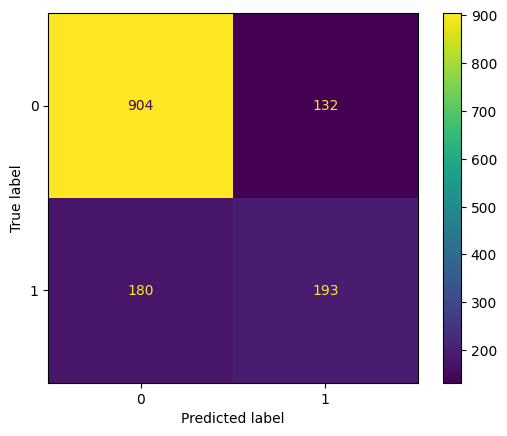

In [40]:
knnmodel = KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)

print('K-Nearest Neighbor')
print()
run_ml(knnmodel, data_path='./WA_Fn-UseC_-Telco-Customer-Churn.csv', test_size=0.2, output_name="knnmodel.joblib")

##Random Forest Classifier Model

Random Forest Classifier

Accuracy: 0.790
F1 Score: 0.790
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1036
           1       0.65      0.45      0.53       373

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



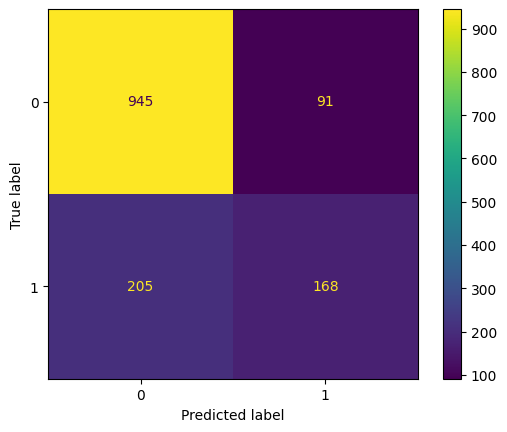

In [41]:
rfmodel = RandomForestClassifier(n_estimators=12, criterion='entropy',random_state=42, bootstrap=True, max_depth=None, max_features='auto')

print('Random Forest Classifier')
print()
run_ml(rfmodel, data_path='./WA_Fn-UseC_-Telco-Customer-Churn.csv', test_size=0.2, output_name="rfmodel.joblib")